# VQE vs AdaptVQE in Li-H ground state search

In [1]:
#install and load pylint eu
!pip install pycodestyle py
%load_ext pycodestyle_magic

  Using cached py-1.10.0-py2.py3-none-any.whl (97 kB)


In [2]:
#%%pycodestyle
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper
from qiskit_nature.algorithms import VQEUCCFactory,GroundStateEigensolver,AdaptVQE

from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SLSQP,L_BFGS_B
from qiskit.utils import QuantumInstance
from qiskit import Aer


from qiskit_mod.qiskit_nature import VHA

import numpy as np 
import time
import math
import matplotlib.pyplot as plt

#CHECK VERSIONS OF QISKIT: 'qiskit-terra': '0.19.0','qiskit-aer': '0.8.2','qiskit-nature': '0.2.0'
import qiskit
print(qiskit.__qiskit_version__)

In [6]:
#%%pycodestyle

distances = np.arange(1, 5, 1)  # angstrom distance


# Initialize qubit converter
qubit_converter = QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True)  # two qubit reduction doesn`t work with Jordan-WignerMapper()

# Initialize Exact solvers & VQE solver
numpy_solver = NumPyMinimumEigensolver()

quantum_instance = QuantumInstance(backend=Aer.get_backend('statevector_simulator'))
optimizer = L_BFGS_B(maxiter=1000)

NameError: name 'np' is not defined

In [30]:
%%pycodestyle

exact_energies, hf_energies, vqe_energies, adapt_vqe_energies, vqe_params, adapt_vqe_params, vha_energies, vha_params = ([] for i in range(8))
trotter_steps = 3
time_step_size = 1

# prepare intial point for VHA, inspired by adiabatic evolution
ip = []
for i in range(trotter_steps):
    ip.append(time_step_size*((i+1)/trotter_steps))  # param for H_ex = V
    ip.append(time_step_size)                        # param for H_hop = H_0
    ip.append(time_step_size)                        # param for H_diag = H_0
print('Initial parameter for VHA, '+str(trotter_steps)+'*(H_ex,H_op,H_diag)=', ip)

for i, bond_distance in enumerate(distances):  # loop over distances
    print('\n step', i, ', bond_distance=', bond_distance)
    molecule = 'H .0 .0 -{0}; Li .0 .0 {0}'
    driver = PySCFDriver(atom=molecule.format(bond_distance/2), unit=UnitsType.ANGSTROM, basis='sto3g')
    qmolecule = driver.run()
    es_problem = ElectronicStructureProblem(driver, q_molecule_transformers=[FreezeCoreTransformer(freeze_core=True, remove_orbitals=[4, 5])])
    vqe_solver = VQEUCCFactory(quantum_instance, optimizer=optimizer)

    # SOLVERS
    # vqe solver
    calc = GroundStateEigensolver(qubit_converter, vqe_solver)
    # adapt vqe solver
    adapt_calc = AdaptVQE(qubit_converter, vqe_solver, threshold=0.001)
    # exact numpy solver
    exact_calc = GroundStateEigensolver(qubit_converter, numpy_solver)

    # vha solver
    vha_solver = VQEUCCFactory(quantum_instance, optimizer=optimizer, initial_point=np.asarray(ip), ansatz=VHA(excitations='sd', trotter_steps=trotter_steps, only_excitations=True))
    calcVHA = GroundStateEigensolver(qubit_converter, vha_solver)

    # Run the computation

    # compute ground state with VHA
    start = time.time()
    resVHA = calcVHA.solve(es_problem)
    vha_energies.append(resVHA.total_energies)
    vha_params.append(len(resVHA.raw_result.optimal_parameters))
    end = time.time()
    print('VHA ,', trotter_steps, 'steps:',
          resVHA.total_energies, ',exec_time=',
          end - start, 's, number of optimal parameters=',
          len(resVHA.raw_result.optimal_parameters))

    # compute ground state with VQE
    start = time.time()
    res = calc.solve(es_problem)
    vqe_energies.append(res.total_energies)
    hf_energies.append(res.hartree_fock_energy)
    vqe_params.append(len(res.raw_result.optimal_parameters))
    end = time.time()
    print('VQE:\t', res.total_energies,
          ',exec_time=', end - start,
          's, number of optimal parameters=', len(res.raw_result.optimal_parameters))

    # compute ground state with AdaptVQE
    start = time.time()
    res2 = adapt_calc.solve(es_problem)
    adapt_vqe_energies.append(res2.total_energies)
    adapt_vqe_params.append(len(res2.raw_result.optimal_parameters))
    end = time.time()
    print('AdaptVQE:', res2.total_energies,
          ',exec_time=', end - start,
          's, number of iterations', res2._num_iterations,
          ',number of optimal parameters=', len(res2.raw_result.optimal_parameters),
          '\n(final max gradient', res2._final_max_gradient,
          'final criterion', res2._finishing_criterion, ')')

    # compute exact ground state
    start = time.time()
    res3 = exact_calc.solve(es_problem)
    exact_energies.append(res3.total_energies)
    end = time.time()
    print('Exact:\t', res3.total_energies, ',exec_time=', end - start, 's')

3:80: E501 line too long (142 > 79 characters)
13:80: E501 line too long (82 > 79 characters)
18:80: E501 line too long (103 > 79 characters)
20:80: E501 line too long (142 > 79 characters)
32:80: E501 line too long (181 > 79 characters)
57:80: E501 line too long (85 > 79 characters)
68:80: E501 line too long (84 > 79 characters)
78:1: W391 blank line at end of file


/home/gsilvi/miniforge3/envs/NEASQC4_exp/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/gsilvi/miniforge3/envs/NEASQC4_exp/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/gsilvi/miniforge3/envs/NEASQC4_exp/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/gsilvi/miniforge3/envs/NEASQC4_exp/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


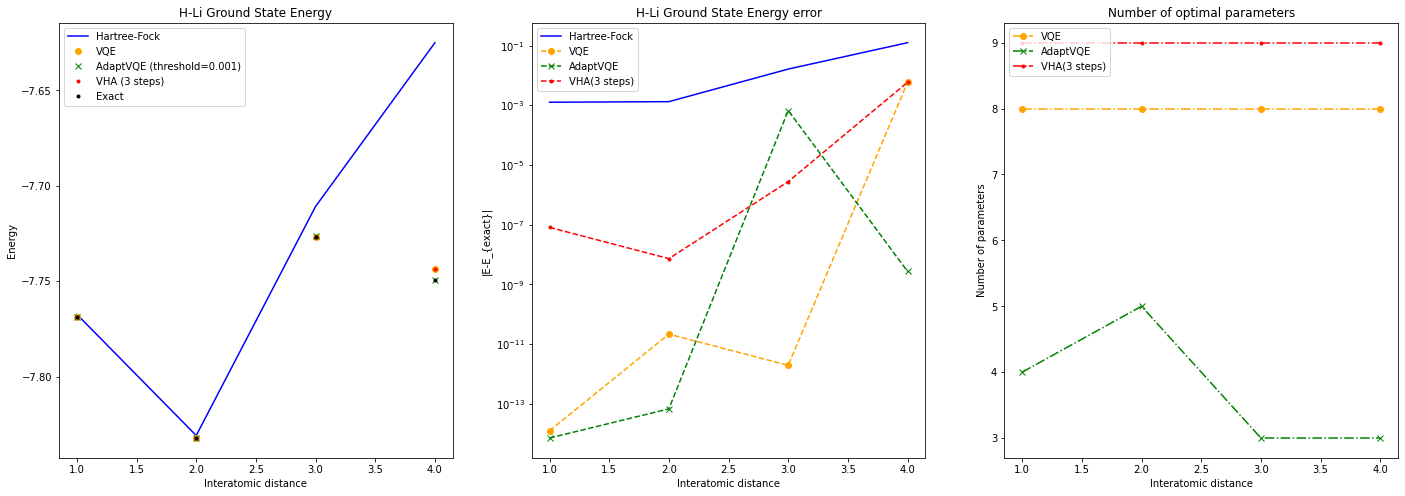

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(24, 8))

ax1.plot(distances,hf_energies,color='blue',label='Hartree-Fock')
ax1.plot(distances,vqe_energies,'o',color='orange',label='VQE')
ax1.plot(distances, adapt_vqe_energies,'x',color='green',label='AdaptVQE (threshold=0.001)')
ax1.plot(distances,vha_energies,'.',color='red',label='VHA ('+str(trotter_steps)+' steps)')
ax1.plot(distances, exact_energies,'.',color='black',label='Exact')
ax1.set_xlabel('Interatomic distance')
ax1.set_ylabel('Energy')
ax1.set_title('H-Li Ground State Energy')
ax1.legend(loc='upper left')


ypoints=[abs(a - b) for a, b in zip(hf_energies,exact_energies)]
ax2.plot(distances,ypoints,color='blue',label='Hartree-Fock')
ypoints=[abs(a - b) for a, b in zip(vqe_energies,exact_energies)]
ax2.plot(distances,ypoints,'o',linestyle='--',color='orange',label='VQE')
ypoints=[abs(a - b) for a, b in zip(adapt_vqe_energies,exact_energies)]
ax2.plot(distances,ypoints,'x',linestyle='--',color='green',label='AdaptVQE')
ypoints=[abs(a - b) for a, b in zip(vha_energies,exact_energies)]
ax2.plot(distances,ypoints,'.',linestyle='--',color='red',label='VHA('+str(trotter_steps)+' steps)')


ax2.set_yscale('log')
ax2.set_xlabel('Interatomic distance')
ax2.set_ylabel('|E-E_{exact}|')
ax2.set_title('H-Li Ground State Energy error')
ax2.legend(loc='upper left') 



ax3.plot(distances,vqe_params,'o',linestyle='-.',color='orange',label='VQE')
ax3.plot(distances, adapt_vqe_params,'x',linestyle='-.',color='green',label='AdaptVQE')
ax3.plot(distances,vha_params,'.',linestyle='-.',color='red',label='VHA('+str(trotter_steps)+' steps)')

ax3.set_xlabel('Interatomic distance')
ax3.set_ylabel('Number of parameters')
ax3.set_title('Number of optimal parameters')
ax3.legend(loc='upper left')


fig.savefig('LiH_ground_energy2.png')